In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
%matplotlib inline

In [60]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [61]:
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

## Building a Custom Dataset class

In [62]:
class MNIST(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X.index)
    
    def __getitem__(self, index):
        image = self.X.iloc[index, ].values.astype(np.uint8).reshape((28, 28, 1))
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.y is not None:
            return image, self.y.iloc[index]
        else:
            return image


## Load train and test datasets and split the training dataset to X and Y 

In [71]:
train = r"C:\Users\shahad\Anaconda3\dlcourse\local git repo\Pytorch\dataset\train.csv"
test = r"C:\Users\shahad\Anaconda3\dlcourse\local git repo\Pytorch\dataset\test.csv"

#1) Read train dataset as CSV 
train_df = pd.read_csv(train)
x_train = train_df.iloc[:,1:] #Remove the label column 
y_train = train_df['label'] 
#2) Read test dataset as CSV
test_df = pd.read_csv(test)


In [73]:

print("The input size: ", train_df.iloc[0].size) #28*28 size 


The input size:  785


In [76]:
#define the transform before initiating the custum dataset
transform = transforms.ToTensor()

train_dataset = MNIST(X=x_train, y=y_train, transform=transform)
print()
test_dataset = MNIST(X=test_df,transform=transform)
print("The length of train dataset is :",len(train_dataset))
print("The length of test dataset is :",len(test_dataset))


The length of train dataset is : 42000
The length of test dataset is : 28000


## Add a validation set

In [77]:
from torch.utils.data.sampler import SubsetRandomSampler

# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_df)
indices = list(range(num_train))
#Shuffle 
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Define loaders 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20,
                                                sampler=valid_sampler)

### Test the defined loaders

In [79]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
print('images shape on PyTroch : ', images.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([20, 1, 28, 28])
labels shape on PyTroch :  torch.Size([20])


## Visualize the Data

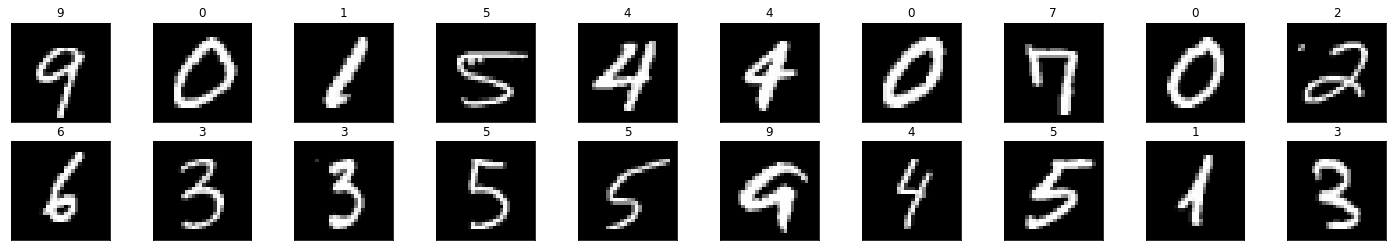

In [80]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Another (and quite simpler) way to visualize the data 

torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([3, 1, 28, 28])


(-0.5, 151.5, 121.5, -0.5)

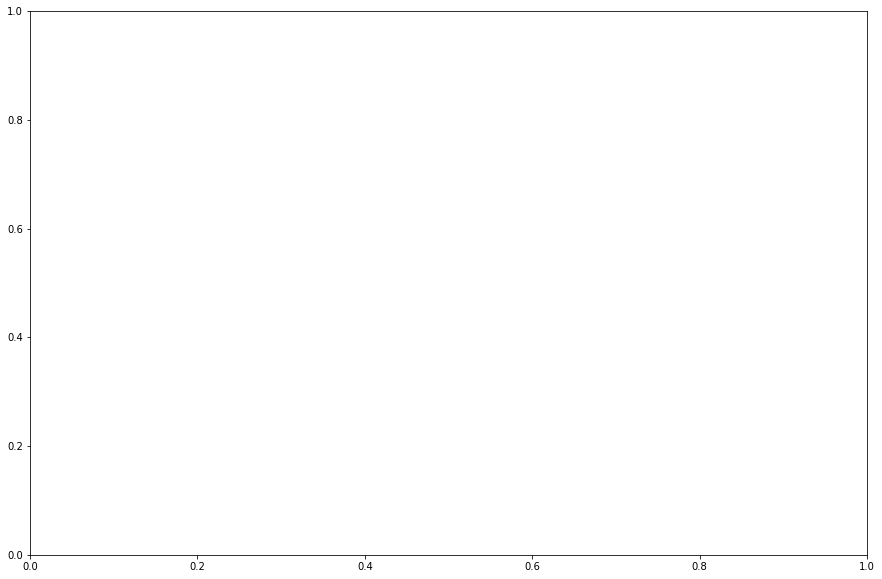

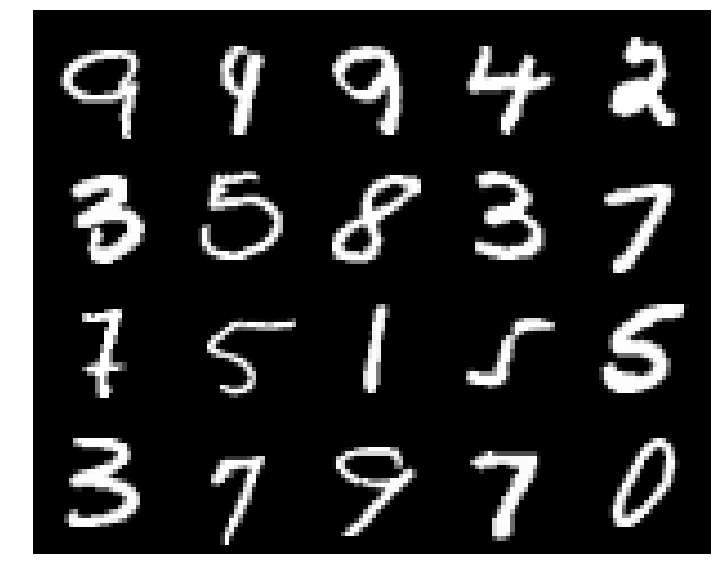

In [136]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(images[:25].shape)
print(images[:3].shape) #Just for testing, any number > 20 will be considered as 20 by default 
grid = make_grid(images[:25], nrow=5)
fig, ax = plt.subplots(figsize=(15, 10))
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(grid.numpy().transpose((1, 2, 0)))
ax.axis('off')

## Define MLP class

In [141]:
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron,self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28*28,hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.fc3 = nn.Linear(hidden_2,10)
        self.dropout = nn.Dropout(.2)
    def forward(self,x):
        #flatten the image input : convert tensor (batch_size, 1, 28, 28) --> (batch_size, 1*28*28)
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
        
# initialize the NN
model = Perceptron()
print(model)
        

Perceptron(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [147]:

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## The steps for training/learning from a batch of data are described in the comments below:

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

In [150]:
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in validation_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.327210 	Validation Loss: 0.272330
Validation loss decreased (inf --> 0.272330).  Saving model ...
Epoch: 2 	Training Loss: 0.280806 	Validation Loss: 0.236181
Validation loss decreased (0.272330 --> 0.236181).  Saving model ...
Epoch: 3 	Training Loss: 0.245321 	Validation Loss: 0.212075
Validation loss decreased (0.236181 --> 0.212075).  Saving model ...
Epoch: 4 	Training Loss: 0.213430 	Validation Loss: 0.188937
Validation loss decreased (0.212075 --> 0.188937).  Saving model ...
Epoch: 5 	Training Loss: 0.190235 	Validation Loss: 0.172829
Validation loss decreased (0.188937 --> 0.172829).  Saving model ...
Epoch: 6 	Training Loss: 0.169817 	Validation Loss: 0.158091
Validation loss decreased (0.172829 --> 0.158091).  Saving model ...
Epoch: 7 	Training Loss: 0.154919 	Validation Loss: 0.146348
Validation loss decreased (0.158091 --> 0.146348).  Saving model ...
Epoch: 8 	Training Loss: 0.140575 	Validation Loss: 0.135410
Validation loss decreased (0.14634